In [3]:
# note: I write all comments in English
!nvidia-smi

Mon Jun  9 03:50:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Imports and Settings

In [4]:
!pip install -U tensorflow_addons albumentations --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 20.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [5]:
import os
import sys
import csv
import random
from time import time
from datetime import timedelta, datetime as dt

import numpy as np
import pandas as pd

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.layers as L
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (Callback, 
                                        ModelCheckpoint, EarlyStopping, 
                                        LearningRateScheduler, ReduceLROnPlateau)
import albumentations as A  # for image augmentation

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Visualization
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10  # increase default plot size
%config InlineBackend.figure_format = 'svg'  # improve svg display
%matplotlib inline

# Discover available data
print('Available data:')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print()
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)
print()
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

Available data:
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy

Python       : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Numpy        : 1.26.4
Tensorflow   : 2.18.0
Keras        : 3.8.0

GPU is available


In [6]:
# Fix dependencies
!pip freeze > requirements.txt

# Random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

## Load Data

> Всего доступно 20 тысяч размеченных изображений размером 48x48 с 3 цветовыми каналами (RGB), поэтому массив images имеет размер (20000, 48, 48, 3). 
> В массиве labels содержатся ответы к тренировочному набору изображений. В английском алфавите 26 букв: 0-й класс соответствует букве А и так далее по алфавиту, 25-й класс — буква Z.

In [7]:
# Input settings
IMG_SIZE = (48, 48)
NUM_CHANNELS = 3  # RGB colored images
NUM_CLASSES = 26  # 26 letters in the English alphabet

In [8]:
# Load Data
DATA_PATH = '/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan'
WORK_PATH = '/kaggle/working/'  # working dir
os.makedirs(WORK_PATH, exist_ok=True)

images = np.load(f'{DATA_PATH}/images.npy')
labels = np.load(f'{DATA_PATH}/labels.npy')

images_submission = np.load(f'{DATA_PATH}/images_sub.npy')
sample_submission = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

## EDA and Data Preprocessing

In [9]:
print('Train images shape:', images.shape)
print('Train labels shape:', labels.shape)
print('Test images shape:', images_submission.shape)

Train images shape: (20000, 48, 48, 3)
Train labels shape: (20000,)
Test images shape: (50000, 48, 48, 3)


Random samples:


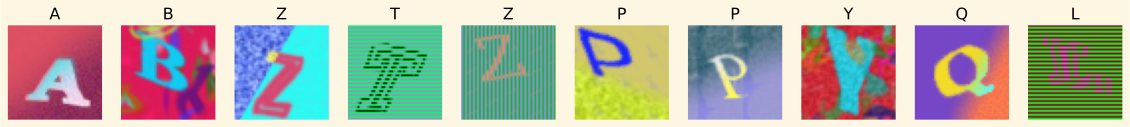

In [10]:
# Preview image samples
def plot_samples(images: np.ndarray, labels: np.ndarray, n=10, grid_shape=None, figsize=(20, 20)):
    if grid_shape is None:
        # cols = int(np.ceil(np.sqrt(n)))
        cols = n
        rows = int(np.ceil(n / cols))
    else:
        rows, cols = grid_shape
    
    random_idx = np.random.choice(images.shape[0], size=n, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for ax, idx in zip(axes, random_idx):
        image = images[idx]
        label = labels[idx]
        ax.imshow(image.astype('uint8'))
        ax.axis('off')
        title = chr(65 + label)
        ax.set_title(title)


print('Random samples:')
plot_samples(images, labels, n=10)

In [11]:
print('Sample submission:')
display(sample_submission)

Sample submission:


,Id,Category
0,0,13
1,1,20
2,2,12
3,3,7
4,4,8
...,...,...
49995,49995,15
49996,49996,4
49997,49997,16
49998,49998,8


In [12]:
# Normalize pixels [0, 255] -> [0, 1]
print(f'Before norm: {images.min()} - {images.max()}')
images = images.astype('float32') / 255
images_submission = images_submission.astype('float32') / 255
print(f'After norm: {images.min()} - {images.max()}')

Before norm: 0 - 255
After norm: 0.0 - 1.0


In [13]:
labels_encoded = to_categorical(labels, num_classes=NUM_CLASSES)
print('One-hot encoded labels shape:', labels_encoded.shape)

One-hot encoded labels shape: (20000, 26)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


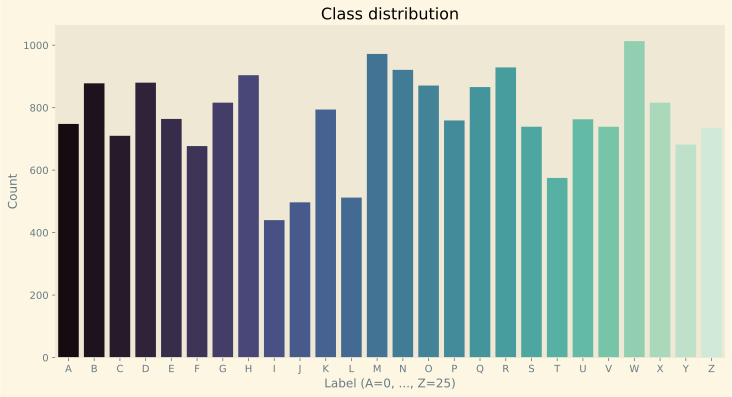

In [26]:
# Count class frequencies
label_counts = Counter(labels)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette='mako')
plt.title('Class distribution')
plt.xlabel('Label (A=0, ..., Z=25)')
plt.ylabel('Count')
plt.xticks(ticks=range(26), labels=[chr(ord('A') + i) for i in range(NUM_CLASSES)])
plt.grid(axis='y')
plt.show();

> class imblance! will use `class_weights`

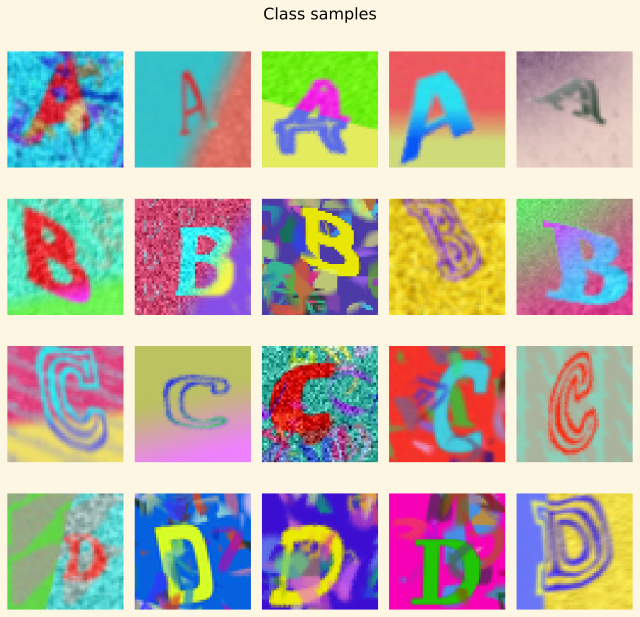

In [23]:
def show_examples_per_class(images, labels, classes=range(NUM_CLASSES), n=5):
    plt.figure(figsize=(9, 9))
    for class_idx in classes:
        idxs = np.where(labels == class_idx)[0][:n]
        for i, idx in enumerate(idxs):
            plt_idx = class_idx * n + i + 1
            plt.subplot(len(classes), n, plt_idx)
            plt.imshow(images[idx])
            plt.axis('off')
            if i == 0:
                plt.ylabel(chr(ord('A') + class_idx), fontsize=12)
    plt.suptitle('Class samples', fontsize=16)
    plt.tight_layout()
    plt.show()

show_examples_per_class(images, labels, classes=range(4))

In [29]:
import hashlib

def hash_image(img):
    return hashlib.sha1(img.tobytes()).hexdigest()

hashes = [hash_image(img) for img in images]
print('Uniques:', len(set(hashes)))
print('Duplicates:', len(images) - len(set(hashes)))

Uniques: 20000
Duplicates: 0


## Split

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

In [30]:
# Train and validation subsets split
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, 
                                                  test_size=0.15, 
                                                  stratify=labels, 
                                                  random_state=RANDOM_SEED)

print('Train:      ', X_train.shape, y_train.shape)
print('Validation: ', X_val.shape, y_val.shape)

Train:       (17000, 48, 48, 3) (17000, 26)
Validation:  (3000, 48, 48, 3) (3000, 26)


## Images Augmentation

Summon image augmentation power to improve recognition quality

Use albumentations library

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  validated_kwargs[param_name] = param.default


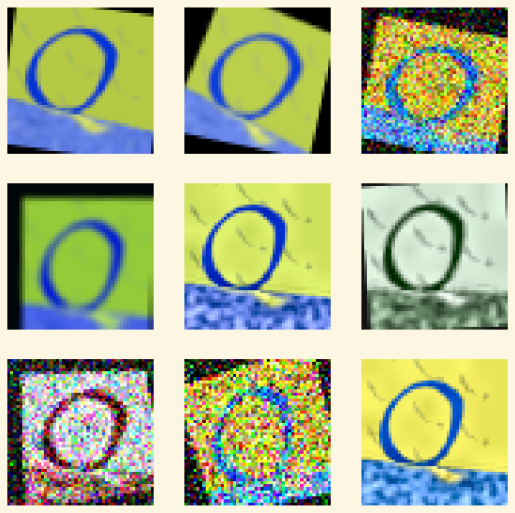

In [33]:
augmentation = A.Compose([
    A.Affine(scale=(0.9, 1.1), 
             translate_percent=(0.1, 0.1), 
             rotate=(-15, 15), p=0.5),

    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, 
                       rotate_limit=15, p=0.5), 

    A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.25, 
                                        contrast_limit=0.25), 
             A.RandomBrightnessContrast(brightness_limit=0.1, 
                                        contrast_limit=0.1)], p=0.2),
    
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=25, 
                         val_shift_limit=0, p=0.5),
    
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, 
               b_shift_limit=10, p=0.3), 
    
    A.ChannelShuffle(p=0.5), 

    A.RandomGamma(p=0.2),
    
    A.CLAHE(clip_limit=2, p=0.3), 

    A.GaussNoise(p=0.15), 
    
    A.Blur(blur_limit=3, p=0.2)
])


fig_size = (9, 9)
plt.figure(figsize=fig_size)
for i in range(9):
    img = augmentation(image=images[10])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# Data Augmentation
# Define function for creating generation objects for image augmentation
def create_datagens():
    train_datagen = ImageDataGenerator(
        rotation_range=10,           # random rotation in degrees
        brightness_range=[0.5, 1.5], # brightness modification
        width_shift_range=0.1,       # horizontal shifting
        height_shift_range=0.1,      # vertical shifting
        shear_range=0.1,             # random shearing
        zoom_range=0.15,             # random zooming

        horizontal_flip=False,       # don't flip horizontally (letters are strict)
        fill_mode='nearest'          # new pixels filling
        # validation_split=VAL_SPLIT
    )

    test_datagen = ImageDataGenerator()
    return train_datagen, test_datagen


# Data generators
datagen.fit(X_train)

## Data Generating Conveyor
Craft data pipeline generators to optimize the usage of compute

In [34]:
def process_image(image):
  return augmentation(image=image.numpy())['image']


def tf_process_dataset_element(image, label):
  im_shape = image.shape
  [image] = tf.py_function(process_image, [image], [tf.float32])
  image.set_shape(im_shape)
  # [text] = tf.py_function(tokenize_text, [text], [tf.int32])
  return image, label

# ------------------------------------------------


BATCH_SIZE = 32

train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(tf_process_dataset_element, num_parallel_calls=tf.data.AUTOTUNE)
    # .shuffle(buffer_size=1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# test_dataset = (
#     tf.data.Dataset.from_tensor_slices((X_test, y_test))
#     .batch(BATCH_SIZE)
#     .prefetch(tf.data.AUTOTUNE)
# )


train_dataset.__iter__().__next__();
val_dataset.__iter__().__next__();
# test_dataset.__iter__().__next__();

I0000 00:00:1749442059.395464      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Model

In [35]:
from tensorflow.keras.applications import EfficientNetV2S


def pretrained_assemble(base, head, name=None):
    output = base.output
    
    for layer in head.layers:
        output = layer(output)

    return Model(inputs=base.input, 
                 outputs=output, 
                 name=name)


base_model = EfficientNetV2S(include_top=False,
                             weights='imagenet', 
                             input_shape=(*IMG_SIZE, NUM_CHANNELS),
                             include_preprocessing=True, 
                             classes=NUM_CLASSES
                             )

head = Sequential([
    L.GlobalAveragePooling2D(), 
    L.Dense(1792, use_bias=True, kernel_regularizer='l2'), 
    L.Dropout(0.5), 
    L.Activation('selu', name='activation_'), 
    L.Dense(896, use_bias=True, kernel_regularizer='l2'), 
    L.Dropout(0.5), 
    L.Activation('selu', name='activation_1_'), 
    L.Dense(448, use_bias=True, kernel_regularizer='l2'), 
    L.Dropout(0.5), 
    L.Activation('selu', name='activation_2_'), 
    L.Dense(224, use_bias=True, kernel_regularizer='l2'), 
    L.Dropout(0.5), 
    L.Activation('selu', name='activation_3_'), 
    L.Dense(NUM_CLASSES, activation='softmax')
])


name = f'noisy_captcha__{base_model.name}_{IMG_SIZE[0]}x{IMG_SIZE[1]}'

model = pretrained_assemble(base_model, head, name)
model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "noisy_captcha__efficientnetv2-s_48x48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 48, 48, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 24, 24, 24)     │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 24, 24, 24)     │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 24, 24, 24)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 24, 24, 24)     │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 24, 24, 24)     │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 24, 24, 24)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 24, 24, 24)     │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 24, 24, 24)     │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 24, 24, 24)     │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 24, 24, 24)     │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 24, 24, 24)     │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 24, 24, 24)     │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv  

 Total params: 24,741,722 (94.38 MB)

 Trainable params: 24,587,850 (93.80 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [214]:
core_ = input_shape[0]
    
model0 = Sequential([
    # Features (Convolutional layers)
    # Block 1
    L.Conv2D(core_, (3, 3), padding='same', input_shape=(*IMG_SIZE, NUM_CHANNELS)),
    L.BatchNormalization(),
    L.ReLU(),
    L.Conv2D(core_, (3, 3), padding='same'),
    L.BatchNormalization(),
    L.ReLU(),
    L.MaxPool2D(pool_size=(2, 2)),
    L.Dropout(0.25),

    # Block 2
    L.Conv2D(core_ * 2, (3, 3), padding='same'),
    L.BatchNormalization(),
    L.ReLU(),
    L.Conv2D(core_ * 2, (3, 3), padding='same'),
    L.BatchNormalization(),
    L.ReLU(),
    L.MaxPool2D(pool_size=(2, 2)),
    L.Dropout(0.25),

    # Block 3
    L.Conv2D(core_ * 4, (3, 3), padding='same'),
    L.BatchNormalization(),
    L.ReLU(),
    L.Conv2D(core_ * 4, (3, 3), padding='same'),
    L.BatchNormalization(),
    L.ReLU(),
    L.MaxPool2D(pool_size=(2, 2)),

    # Classifier (Dense layers)
    L.Flatten(),
    L.Dense(core_ * 16),
    L.BatchNormalization(),
    L.ReLU(),
    L.Dropout(0.3),
    L.Dense(core_ * 8),
    L.BatchNormalization(),
    L.ReLU(),
    L.Dropout(0.2),

    L.Dense(NUM_CLASSES, activation='softmax')
])

# Config Lion optimizer
optimizer0 = optimizers.Lion(
    learning_rate=LR,
    weight_decay=1e-4
)

# Compile model
model0.compile(
    optimizer=optimizer0,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model structure
model0.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)                   │ (None, 48, 48, 48)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 48, 48, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_42 (ReLU)                      │ (None, 48, 48, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 48, 48, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 48, 48, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_43 (ReLU)                      │ (None, 48, 48, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 24, 24, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 24, 24, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 24, 24, 96)          │          41,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 24, 24, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_44 (ReLU)                      │ (None, 24, 24, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 24, 24, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 24, 24, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_45 (ReLU)                      │ (None, 24, 24, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 12, 12, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 12, 12, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 12, 12, 192)         │         166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 12, 12, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_46 (ReLU)                      │ (None, 12, 12, 192)         │              

 Total params: 6,266,570 (23.91 MB)

 Trainable params: 6,262,922 (23.89 MB)

 Non-trainable params: 3,648 (14.25 KB)

### Callbacks Interface¶

https://keras.io/callbacks/

In [38]:
# Create a callback to log duration for each epoch
class TimingCallback(Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime=time()
    def on_epoch_end(self, epoch, logs={}):
        t = time() - self.starttime
        self.logs.append(round(t))

In [39]:
LR_DECAY_RATE = 0.9

# Define function for callbacks list creation
def recreate_callbacks():
    timing = TimingCallback()
    
    callbacks_list = [# save the progress of the model training 
                      # in order to later and fine-tune the model:
                      ModelCheckpoint('best_model.keras',    
                                      monitor='val_accuracy', 
                                      verbose=1, 
                                      mode='max', 
                                      save_best_only=True), 
                      
                      # stop the learning process if the target metric 'patience' 
                      # doesn't improve for consecutive epochs (prevent overfitting):
                      EarlyStopping(monitor='val_accuracy', 
                                    patience=10, 
                                    restore_best_weights=True), 

                      # gradually decrease LR after each epoch:
                      LearningRateScheduler(lambda x: LR * LR_DECAY_RATE ** x, 
                                            verbose=1), 
                      
                      # log epochs timings:
                      timing]
    return callbacks_list

In [ ]:
def show_metric(src):
    print({i + 1: round(src[i], 4) for i in range(len(src))})

def show_stats(history):
    print('TRAINING STATS\n--------------\n')
    print(f'Base model: {base_model.name}; Optimizer: {model.optimizer._name}')
    print(f'IMG_SIZE: {IMG_SIZE}; BATCH_SIZE: {BATCH_SIZE};', 
          f'LR: {LR}; DROPOUT_RATE: {DROPOUT_RATE}')
    
    print('\nval_accuracy:')
    va = history.history['val_accuracy']
    show_metric(va)
    print('best:', round(max(va), 4))
    
    print('\nTimings:')
    show_metric(callbacks_list.timing.logs)
    
    print('\nTotal training time:')
    print(timedelta(seconds=sum(callbacks_list.timing.logs)))
    
def plot_history(history):
    plt.style.use('Solarize_Light2')
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Train

In [ ]:
LR = 0.0001

# Let try out a relatively new Lion optimizer
model.compile(optimizer=optimizers.Lion(learning_rate=LR, weight_decay=0.004), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=80,
    batch_size=32,
    callbacks=recreate_callbacks(), 
    class_weight=class_weight_dict
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/20


I0000 00:00:1749442295.088247     133 service.cc:148] XLA service 0x7fc580106e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749442295.088848     133 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749442303.994594     133 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749442318.119146     133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442318.297808     133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442318.644207     133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442318.8204

531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0648 - loss: 32.7096

E0000 00:00:1749442439.810271     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442439.985813     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442440.358729     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442440.540688     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749442440.912071     135 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

In [ ]:
print('Evaluation on the validation set:')
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f'Loss потеря: {val_loss:.4f}')
print(f'Accuracy: {val_accuracy:.4f}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict

Make predictions on the Test set

In [211]:
print('Making test set predictions..')
predictions = model.predict(images_submission)
y_pred = np.argmax(predictions, axis=1)

Making test set predictions..
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step


## Submission

In [213]:
submission = pd.DataFrame({
    'Id': sample_submission['Id'],
    'Category': y_pred
})

# Save submission as CSV
submission.to_csv(f'{WORK_PATH}/submission.csv', index=False)

print('submission.csv ready!')
display(submission.head())

submission.csv ready!


,Id,Category
0,0,19
1,1,8
2,2,14
3,3,12
4,4,10
